In [1]:
import sinter
import matplotlib.pyplot as plt
import numpy as np
from erasure_simulator import *
import pandas as pd
import multiprocessing


import sys
sys.path.append('./gidney_code/src')
from hookinj.gen import NoiseModel, NoiseRule
from hookinj._make_circuit import *

%load_ext autoreload
%autoreload 2

# gather

In [2]:
df = pd.DataFrame()
for i in range(0,20):
    # c = 5 if i < 63 else 6
    df = pd.concat([df,pd.read_csv(f"./out/collection/expand_raw,{i},2024-12-16,batch_size=500.csv")])
# df = pd.read_csv("./out/collection/expand_simulation,2024-11-26,num_circuits=100000.csv")
df

,Unnamed: 0,strong_id,decoder,json_metadata,shots,errors,discards,seconds,custom_counts,d,e,p,r,id
0,0,d7e8753104cb4deba9354412c8e16e01d95b3e36806947...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'id': 36}",5000,2,0,18.899544,Counter(),3,0.00,0.0010,2,36
1,1,802c661677f0d7451c0d224a798182b0ac46d0cf3b0163...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'id': 40}",5000,3,0,18.829704,Counter(),3,0.00,0.0010,2,40
2,2,973fe906b8da7beff2b074d1dc5e518f00f4dd9a512928...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'id': 3}",5000,3,0,20.020583,Counter(),3,0.00,0.0010,2,3
3,3,686f77352a8d9d5fb3fe9d67f08a6a7f255e229be76c1f...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'id': 32}",5000,2,0,19.216496,Counter(),3,0.00,0.0010,2,32
4,4,46b8bb085ee419a4e7bdf2107ee997100e0bd56a9eecb2...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'id': 2}",5000,4,0,20.138743,Counter(),3,0.00,0.0010,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7995,d0836a7440826040caf7a9e471562cbb0b9de396188aec...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,2.925498,Counter(),9,0.01,0.0001,2,493
7996,7996,3062a9e4fb1d86e624164c07fec42eb28ede42ad146109...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,3.424333,Counter(),9,0.01,0.0001,2,480
7997,7997,9fd501859b5d61e678b5924f23da318f79c185e5f88ca5...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,2.121184,Counter(),9,0.01,0.0001,2,499
7998,7998,32bdd2556ee5dd0adfafb30f361eccecfca54ea208e6d0...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,4.134444,Counter(),9,0.01,0.0001,2,473


In [3]:
import ast
metadata = ast.literal_eval(df['json_metadata'].iloc[0])  # from string to dict
df['json_metadata'] = df['json_metadata'].apply(lambda d: ast.literal_eval(d))
df['json_metadata'].apply(lambda d: d.pop('id', None))  # Since dict is mutable, we can modify it in place
df['json_metadata'] = df['json_metadata'].astype(str)
df['error_rate_per_circuit'] = df['errors'] / (df['shots'] - df['discards'])
df['var_per_circuit'] = df['error_rate_per_circuit'] * (1-df['error_rate_per_circuit']) / (df['shots'] - df['discards'])

# df_grouped = df.groupby('json_metadata').agg({'shots': 'sum', 'errors': 'sum', 'discards': 'sum', 'seconds': 'sum',
#                                               'decoder': 'first', 'var_per_circuit': 'mean', 'error_rate_per_circuit': 'var'} 
#                                             | {key: 'first' for key in metadata.keys()})

df_grouped = df.groupby('json_metadata').agg({
    'shots': 'sum',
    'errors': 'sum',
    'discards': 'sum',
    'seconds': 'sum',
    'decoder': 'first',
    'var_per_circuit': 'mean',
    'error_rate_per_circuit': 'var',
    'strong_id': 'count',
} | {key: 'first' for key in metadata.keys()})
df_grouped = df_grouped.rename(columns={'error_rate_per_circuit': 'Var(E(X|Y))', 'var_per_circuit': 'E(Var(Y|X))', 'strong_id': 'num_circuits'})
df_grouped['error_rate'] = df_grouped['errors'] / (df_grouped['shots'] - df_grouped['discards'])
# df_grouped['total_var'] = df_grouped['E(Var(Y|X))']/10000 + df_grouped['Var(E(X|Y))'].fillna(0)
df_grouped['total_var'] = df_grouped.error_rate * (1-df_grouped.error_rate) / df_grouped['shots'] #+ df_grouped['Var(E(X|Y))'].fillna(0) / df_grouped['num_circuits']
df_grouped

,shots,errors,discards,seconds,decoder,E(Var(Y|X)),Var(E(X|Y)),num_circuits,d,e,p,r,id,error_rate,total_var
json_metadata,,,,,,,,,,,,,,,
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2}",50000000,39182,0,79040.634008,pymatching,1.565743e-07,1.545078e-07,10000,3,0.000,0.0010,2,36,7.836400e-04,1.566052e-11
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2}",50000000,1821,0,79014.535706,pymatching,7.277498e-09,3.118470e-08,10000,3,0.001,0.0001,2,5,3.642000e-05,7.283735e-13
"{'d': 3, 'e': 0.004, 'p': 0.0001, 'r': 2}",50000000,10917,0,82781.933872,pymatching,3.862528e-08,2.516842e-05,10000,3,0.004,0.0001,2,23,2.183400e-04,4.365847e-12
"{'d': 3, 'e': 0.01, 'p': 0.0001, 'r': 2}",50000000,87934,0,94189.153086,pymatching,2.503465e-07,5.039049e-04,10000,3,0.010,0.0001,2,12,1.758680e-03,3.511174e-11
"{'d': 5, 'e': 0, 'p': 0.001, 'r': 2}",50000000,2459,0,78075.104626,pymatching,9.833570e-09,9.730301e-09,10000,5,0.000,0.0010,2,7,4.918000e-05,9.835516e-13
"{'d': 5, 'e': 0.001, 'p': 0.0001, 'r': 2}",50000000,15,0,78534.906732,pymatching,5.998800e-11,5.991599e-11,10000,5,0.001,0.0001,2,0,3.000000e-07,5.999998e-15
"{'d': 5, 'e': 0.004, 'p': 0.0001, 'r': 2}",50000000,211,0,82879.977706,pymatching,8.437384e-10,1.290321e-09,10000,5,0.004,0.0001,2,7,4.220000e-06,8.439964e-14
"{'d': 5, 'e': 0.01, 'p': 0.0001, 'r': 2}",50000000,7245,0,94547.541673,pymatching,2.387941e-08,2.548450e-05,10000,5,0.010,0.0001,2,22,1.449000e-04,2.897580e-12
"{'d': 7, 'e': 0, 'p': 0.001, 'r': 2}",50000000,161,0,77752.506368,pymatching,6.438712e-10,6.336950e-10,10000,7,0.000,0.0010,2,3,3.220000e-06,6.439979e-14


# Plot

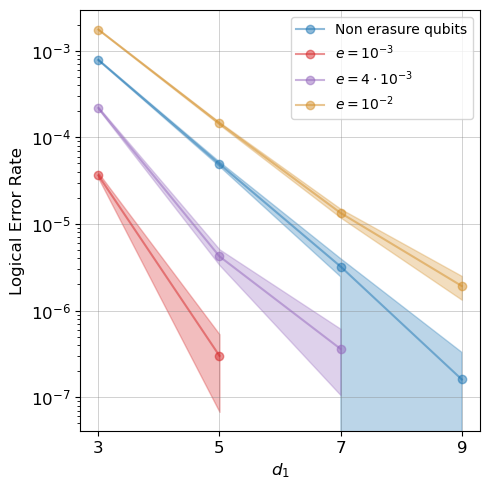

In [ ]:
import matplotlib.pyplot as plt
from datetime import date
from itertools import cycle
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

label_fontsize = 12
title_fontsize = 12
legend_fontsize = 10

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

colors = ['#1f77b4',  # Blue
          '#d62728',  # Red
          '#9467bd',  # Purple
          # '#ff7f0e',  # Orange
          '#d48f28',  # Medium-Dark Orange
          # '#2ca02c',  # Green
         ]
color_generator = cycle(colors)

e_label_dict = {
    0: 'Non erasure qubits',
    1e-3: '$e=10^{-3}$',
    4e-3: '$e=4 \\cdot 10^{-3}$',
    1e-2: '$e=10^{-2}$',
}


con_int = 3 #1.96

for e in df_grouped['e'].unique():
    color = next(color_generator)
    e_df = df_grouped[(df_grouped.e==e) & (df_grouped.error_rate !=0)]
    ax.errorbar(e_df.d, e_df.error_rate, fmt = 'o-', label=e_label_dict[e], color=color, alpha=0.5,
    )
    ax.fill_between(
        e_df.d, 
        e_df.error_rate - con_int * np.sqrt(e_df['total_var']),
        e_df.error_rate + con_int * np.sqrt(e_df['total_var']),
        alpha=0.3,
        color = color,
    )


ax.set_yscale('log')
# ax.set_ylim(1e-6,1e-2)
ax.legend(fontsize = legend_fontsize)
ax.set_xlabel('$d_1$', fontsize = label_fontsize)
ax.set_ylabel('Logical Error Rate', fontsize = label_fontsize)

ax.set_xticks(df_grouped['d'].unique())
ax.grid(which='major', alpha=0.5, linewidth='0.5', color='gray')
ax.tick_params(labelsize=label_fontsize)
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# fig.set_dpi(120)  # Show it bigger
fig.tight_layout()
plt.savefig(f"./out/figures/expansion_for_d,{date.today()}.svg")
plt.show()

# Fit

In [2]:
df = pd.DataFrame()
for i in range(0,20):
    # c = 5 if i < 63 else 6
    df = pd.concat([df,pd.read_csv(f"./out/collection/expand_raw,{i},2025-01-29,batch_size=500.csv")])
# df = pd.read_csv("./out/collection/expand_simulation,2024-11-26,num_circuits=100000.csv")
df

,Unnamed: 0,strong_id,decoder,json_metadata,shots,errors,discards,seconds,custom_counts,d,e,p,r,id
0,0,e49dca94b005c5ea3c590654a2fe58c384256f9d158af8...,pymatching,"{'d': 3, 'e': 0, 'p': 9.999999999999999e-05, '...",5000,0,0,7.733143,Counter(),3,0.00,0.0001,2,102
1,1,2c54891416f040b163f2c41aecf68e561ad1b5c0401a75...,pymatching,"{'d': 3, 'e': 0, 'p': 9.999999999999999e-05, '...",5000,0,0,8.200210,Counter(),3,0.00,0.0001,2,20
2,2,bceb19f7db2942b40b84fd3fd565c7234b3532aa46ab22...,pymatching,"{'d': 3, 'e': 0, 'p': 9.999999999999999e-05, '...",5000,0,0,8.223903,Counter(),3,0.00,0.0001,2,56
3,3,3c820a7280208e69421ba678cf13a644d4e16d09b67b08...,pymatching,"{'d': 3, 'e': 0, 'p': 9.999999999999999e-05, '...",5000,0,0,7.284868,Counter(),3,0.00,0.0001,2,165
4,4,da20b18fb606fae26ede63292731e2e9fa87e8541c7c03...,pymatching,"{'d': 3, 'e': 0, 'p': 9.999999999999999e-05, '...",5000,0,0,8.155298,Counter(),3,0.00,0.0001,2,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,672fdd60bde748d7e8495f8e4ab56e4d7ecc272737764b...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,2.134378,Counter(),9,0.01,0.0001,2,496
39996,39996,77cf92437cb4c240387c7c94540ba7957a1663f24f7c81...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,2.097551,Counter(),9,0.01,0.0001,2,498
39997,39997,90e944cb2b4103a8fb266ddf05838754e1cba2b6a6c1be...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,3.027230,Counter(),9,0.01,0.0001,2,487
39998,39998,8b8fb5d6f59f6a7f062b5c2696ce866e16d0b5531108b7...,pymatching,"{'d': 9, 'e': 0.01, 'p': 0.0001, 'r': 2, 'id':...",5000,0,0,2.830974,Counter(),9,0.01,0.0001,2,493


In [3]:
import ast
metadata = ast.literal_eval(df['json_metadata'].iloc[0])  # from string to dict
df['json_metadata'] = df['json_metadata'].apply(lambda d: ast.literal_eval(d))
df['json_metadata'].apply(lambda d: d.pop('id', None))  # Since dict is mutable, we can modify it in place
df['json_metadata'] = df['json_metadata'].astype(str)
df['error_rate_per_circuit'] = df['errors'] / (df['shots'] - df['discards'])
df['var_per_circuit'] = df['error_rate_per_circuit'] * (1-df['error_rate_per_circuit']) / (df['shots'] - df['discards'])

# df_grouped = df.groupby('json_metadata').agg({'shots': 'sum', 'errors': 'sum', 'discards': 'sum', 'seconds': 'sum',
#                                               'decoder': 'first', 'var_per_circuit': 'mean', 'error_rate_per_circuit': 'var'} 
#                                             | {key: 'first' for key in metadata.keys()})

df_grouped = df.groupby('json_metadata').agg({
    'shots': 'sum',
    'errors': 'sum',
    'discards': 'sum',
    'seconds': 'sum',
    'decoder': 'first',
    'var_per_circuit': 'mean',
    'error_rate_per_circuit': 'var',
    'strong_id': 'count',
} | {key: 'first' for key in metadata.keys()})
df_grouped = df_grouped.rename(columns={'error_rate_per_circuit': 'Var(E(X|Y))', 'var_per_circuit': 'E(Var(Y|X))', 'strong_id': 'num_circuits'})
df_grouped['error_rate'] = df_grouped['errors'] / (df_grouped['shots'] - df_grouped['discards'])
# df_grouped['total_var'] = df_grouped['E(Var(Y|X))']/10000 + df_grouped['Var(E(X|Y))'].fillna(0)
df_grouped['total_var'] = df_grouped.error_rate * (1-df_grouped.error_rate) / df_grouped['shots'] #+ df_grouped['Var(E(X|Y))'].fillna(0) / df_grouped['num_circuits']
df_grouped

,shots,errors,discards,seconds,decoder,E(Var(Y|X)),Var(E(X|Y)),num_circuits,d,e,p,r,id,error_rate,total_var
json_metadata,,,,,,,,,,,,,,,
"{'d': 3, 'e': 0, 'p': 0.00012915496650148838, 'r': 2}",50000000,603,0,33800.611877,pymatching,2.411490e-09,2.402797e-09,10000,3,0.000000,0.000129,2,2,1.206000e-05,2.411971e-13
"{'d': 3, 'e': 0, 'p': 0.0001668100537200059, 'r': 2}",50000000,991,0,33737.755915,pymatching,3.963134e-09,3.939562e-09,10000,3,0.000000,0.000167,2,5,1.982000e-05,3.963921e-13
"{'d': 3, 'e': 0, 'p': 0.00021544346900318845, 'r': 2}",50000000,1670,0,34017.770384,pymatching,6.678451e-09,6.629103e-09,10000,3,0.000000,0.000215,2,0,3.340000e-05,6.679777e-13
"{'d': 3, 'e': 0, 'p': 0.0002782559402207126, 'r': 2}",50000000,2821,0,34225.280761,pymatching,1.128106e-08,1.149393e-08,10000,3,0.000000,0.000278,2,41,5.642000e-05,1.128336e-12
"{'d': 3, 'e': 0, 'p': 0.00035938136638046257, 'r': 2}",50000000,4751,0,34170.903596,pymatching,1.899845e-08,1.874507e-08,10000,3,0.000000,0.000359,2,14,9.502000e-05,1.900219e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"{'d': 9, 'e': 0.003593813663804626, 'p': 3.5938136638046256e-05, 'r': 2}",50000000,0,0,38583.457516,pymatching,0.000000e+00,0.000000e+00,10000,9,0.003594,0.000036,2,0,0.000000e+00,0.000000e+00
"{'d': 9, 'e': 0.004641588833612777, 'p': 4.641588833612777e-05, 'r': 2}",50000000,0,0,40713.691821,pymatching,0.000000e+00,0.000000e+00,10000,9,0.004642,0.000046,2,0,0.000000e+00,0.000000e+00
"{'d': 9, 'e': 0.005994842503189409, 'p': 5.994842503189409e-05, 'r': 2}",50000000,4,0,43227.885839,pymatching,1.599680e-11,1.599520e-11,10000,9,0.005995,0.000060,2,15,8.000000e-08,1.600000e-15


R=0.0
fitting: np.log(a/d) + c * d * np.log(p / b)
Fitted parameters: a = 0.2820380574773798, b = 0.010016859691542333, c = 0.5174679433679095
slope = -2.251509203980966
r2=0.9883514871879557


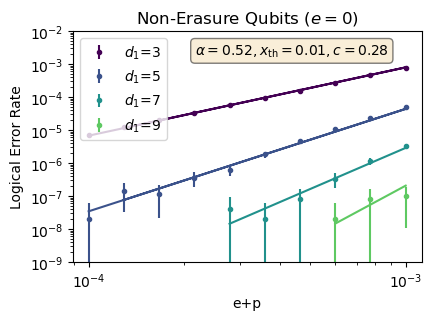

R=99.0
fitting: np.log(a/d) + c * d * np.log(p / b)
Fitted parameters: a = 0.1728922963868688, b = 0.03883728950086167, c = 0.7010028555323427
slope = -2.5582612182886764
r2=0.9678736775943317


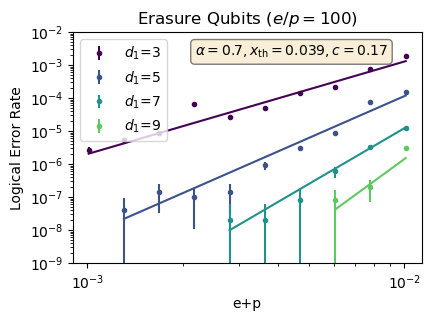

In [90]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import date


def r_squared(y_obs, y_fit):
    ss_res = np.sum((y_obs - y_fit) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Define the function in log space
def model(pd, a, b, c):
    p, d = pd
    return np.log(a/d) + c * (d+1)* np.log(p / b)  # Logarithmic transformation

for R in (df_grouped['e'] // df_grouped['p']).unique():
    R_df = df_grouped[((df_grouped['e'] // df_grouped['p']) == R) & (df_grouped.error_rate != 0)]
    
    print(f"{R=}")
    print("fitting: np.log(a/d) + c * d * np.log(p / b)")
    
    if len(R_df) < 4:
        print(f"{len(R_df)}")
        continue
    
    # Example data
    p_data = R_df['e'] + R_df['p']
    d_data = R_df['d']
    pL_data = np.log(R_df['error_rate'])  # Taking the log of error_rate
    err_var = R_df['total_var']
    
    # Combine x and y into a single array for curve fitting
    pd_data = (p_data, d_data)
    
    # Initial guesses for log-space parameters
    initial_guess = [0.1, 0.01, 0.7]
    
    # Perform the curve fitting in log-space
    popt, pcov = curve_fit(model, pd_data, pL_data, p0=initial_guess)
    
    # Extract fitted parameters and revert log transformation
    a_fit, b_fit, c_fit = popt
    # a_fit = np.exp(log_a_fit)  # Convert back from log-space
    
    print(f"Fitted parameters: a = {a_fit}, b = {b_fit}, c = {c_fit}")
    print(f"slope = {c_fit * np.log(p_data.iloc[0] / b_fit)}")  # Using iloc for the first element
    
    # Predict values using the fitted model in log-space, then exponentiate
    pL_fit = np.exp(model(pd_data, *popt))  # Convert back from log-space

    
    # Compute R-squared
    r2 = r_squared(pL_data, np.log(pL_fit))  # Convert log values back
    print(f"{r2=}")
    
    # Plot the results
    plt.figure(figsize=(4.5, 3))
    for d_1 in d_data.unique():
        color = plt.cm.viridis(d_data.unique().tolist().index(d_1) / len(d_data.unique()))
        # plt.scatter(p_data[d_data==d_1], np.exp(pL_data)[d_data==d_1], marker='.', label=f"$d_1$={d_1}")  # Convert back to original scale
        plt.errorbar(p_data[d_data==d_1], np.exp(pL_data)[d_data==d_1], fmt='.', label=f"$d_1$={d_1}", yerr = 2 * np.sqrt(err_var[d_data==d_1]), color=color)
        plt.plot(p_data[d_data==d_1], pL_fit[d_data==d_1], color=color)
    plt.xlabel("e+p")
    plt.ylabel("logical error rate".title())
    # plt.yscale('log')  # Keep the logarithmic scale
    plt.loglog()
    plt.ylim(1e-9,1e-2)
    plt.title(f"Non-Erasure Qubits ($e=0$)" if R==0 else "Erasure Qubits ($e/p=100$)")
    plt.legend(loc = 'upper left')
    

    textstr = f"$\\alpha = {c_fit:.2}, x_\\text{{th}} = {b_fit:.2}, c={a_fit:.2}$"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.35, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

    plt.savefig(f"./out/figures/expansion_fit,{date.today()},{R}.svg")
    plt.show()
